### Bias detection study - L03

Third part of bias detection study will focus on adjustment of shooting strategy based on detected bias pattern.

Once we confirm the bias pattern and determine the biased metrics distibution aswell as biased ship placement heatmap, we can adapt our shooting strategy to match those. We can do that by weighting the randomly generated boards in monte-carlo approach (or bruteforce generated in ADV method) with some weight factors. The very first idea that I came up with was that the total weight factor can be either an average or a product of individual weights from each metric, determined as (desired_mean_metric_value / randomly_generated_mean_metric_value). But it's not that simple because the metrics are not independent from each other, so multiplying their weights would double-account some features and undervalue others. This would also neglect very useful information about the metrics distribution that we gathered.


The only robust way to approach this problem that I can think of is machine learning - employing classifier model which can predict likelyhood of certain board setup appearing in either random boards set or the biased boards set. The ratio of these likelyhoods can become the weight factor for considered board.


The goal of this part of the study is to create a classifier model based on two sets of boards and process its predictions into a weight factor. This in the end will have to be validated by randomly generating a third set of boards, applying proper weights to them and checking if the metric distributions in this third, weighted board set come closer to match the biased set.



We will again use the relational-biased board dataset from previos parts of the study. We concatenate both sets into one dataframe with labels - 0 for random distribution, 1 for biased.

In [1]:
import numpy as np
import pandas as pd

random_boards_df = pd.read_csv("bias_checks\\random_boards_bruteforce_uniform.csv")
random_boards_df['label'] = 0
random_boards = random_boards_df['board'].tolist()

biased_boards_df = pd.read_csv("bias_checks\\biased_2seg_close_10000.csv")
biased_boards_df['label'] = 1
biased_boards = biased_boards_df['board'].tolist()

all_boards_df = pd.concat([random_boards_df, biased_boards_df], ignore_index=True)
all_boards_df.set_index('board', inplace=True)

We calculate metrics and add their values in new dataframe columns. 

I know, the code below is far from being the most efficient to do it, but it only needs to be run once, then we will just load the csv.

In [2]:
import bias_metrics

if False:
    for board_code in all_boards_df.index:
        board_array = np.array([int(x) for x in board_code]).reshape((6,6))
        current_metrics = bias_metrics.calculate_bias_metrics(board_array)

        for metric_name, metric_value in current_metrics.items():
            all_boards_df.at[board_code, metric_name] = metric_value

    print(all_boards_df.head())
    all_boards_df.to_csv("bias_checks\\all_boards_with_metrics.csv")

all_boards_df = pd.read_csv("bias_checks\\all_boards_with_metrics.csv", index_col=0)

We have in total 10k random and 10k biased boards. To train the model we will use all random boards that we have (in real game scenario we always have those available) and only 5k biased boards. We will see if we can fit to the remaning 5k biased boards.

Since the class are not balanced, we will need to calculate class weights. Some methods allow class_weights="balanced" parameter, but doing it manually leaves us with some more flexibility.

In [3]:
def get_class_weights(df):
    n_R = len(df[df['label'] == 0])
    n_B = len(df[df['label'] == 1])

    pi_R = n_R / (n_R + n_B)
    pi_B = n_B / (n_R + n_B)

    return pi_R, pi_B

red_boards_df = all_boards_df[:15000]
X = red_boards_df.drop(columns=['label'])

class_weights = get_class_weights(red_boards_df)

The data for classifier must obviously be scaled. Since our distribution types differ, we shall robust scaler.

We will only need random_boards_df to create the scaler, because it already contains all possible board setups.

In [4]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression

df_for_scaler = all_boards_df[:10000].drop(columns=['label'])

scaler = RobustScaler().fit(df_for_scaler)
Xs = scaler.transform(X)

Simple LogisticRegression model from sklearn will be used in this study. It does not support online model updates with new training data batches (might be useful in final application in the game, so that the model is not recalculated from scratch everytime we provide data from new board setups), but for now it will be fair enough.

The regularization type I'm using here is "L2". The model will not be easily explainable, but thinking abo the above issue, it should enable smoother transition when new train data is added instead of sudden jumps that might appear when L1 activates or discards some metrics entirely.


In [5]:
clf = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=500
)

clf.fit(Xs, red_boards_df['label'])

LogisticRegression(max_iter=500)

Checking the accuracy of the model does not make any sense, because one board code can have both random and biased label assigned, but with differnet likelyhood. The only reliable way to measure what we care for is checking the similarity of the biased distrubution with the distribution that we achieve through random sampling with weights determined using this model. I expect that the model optimization task will not be an easy one, because of this indirect testing method aswell as the fact that efficiency of different models likely vary dependng on number of available data.

For now, let's make predictions with the model that we have and develop a testing method.

I already learned the hard way that making the prediction for each board individually once it's generated is painfully inefficient. It's better to run it in batches (let's say 100 boards per batch) and it doesn't hurt us at all - we anyway usually need to generate thousands of boards to count occurances from.

While optimizing these operations I also learned that scaler.transform method is also quite inefficient and same could be achieved by doing it manually using scaler parameters (scaler.center_, scaler.scale_) extracted from the scaler class once it's created.

In [6]:
scaler_params=(scaler.center_, scaler.scale_, X.columns.tolist())

def prepare_new_data_batch(generated_boards, scaler_params):
    
    center, scale, feature_order = scaler_params

    N = len(generated_boards)
    F = len(feature_order)

    X = np.zeros((N, F), dtype=np.float64)

    for i, board in enumerate(generated_boards):
        metrics = bias_metrics.calculate_bias_metrics(board)   # returns dict

        # Convert metrics dict -> ordered row vector
        X[i] = [metrics[m] for m in feature_order]

        x_scaled = (X - center) / scale

    return x_scaled


def predict_LR_new_boards(new_boards_s, class_weights, clf):

    pi_R, pi_B = class_weights
    c = clf.predict_proba(new_boards_s)
    p = c[:, 1] # probability of being in biased class

    odds = p / (1 - p)
    LR_hat = odds * (pi_R / pi_B)

    return LR_hat

The function below will sample N amount of random boards from the random_boards list, scale them with scaler_params and use the clf classifier model to predict weights. Then, the weights will be normalized such that all are >=1. For each board, its normalized weight will be a number of this board's instances in a new "adjusted_boards" list in which we will need to study the distribution of metrics.

I define np.random.seed as 10 to get reproducible results. 

In [7]:
np.random.seed(10)

def sample_adjusted_boards(random_boards, clf, scaler_params, class_weights, size):

    new_boards = np.random.choice(random_boards, size=size, replace=True)
    new_boards_arrays = [np.array([int(x) for x in board_code]).reshape((6,6)) for board_code in new_boards]

    new_boards_s = prepare_new_data_batch(new_boards_arrays, scaler_params)
    weights = predict_LR_new_boards(new_boards_s, class_weights, clf)

    # Clipping between 0.1 and 10 to avoid extreme numbers
    weights = np.clip(weights, 0.1, 10.0)
    weights = np.round(weights, 3)

    min_weight = min(weights)
    normalized_weights = [weight / min_weight for weight in weights]

    adjusted_boards = []
    for board, weight in zip(new_boards, normalized_weights):
        for _ in range(int(round(weight))):
            adjusted_boards.append(board)

    return adjusted_boards

adjusted_boards = sample_adjusted_boards(random_boards, clf, scaler_params, class_weights, size = 4096)

To calculate the metrics and get their distribution we will need to reimplement the get_metrics and wasserstein_similarity functions from the previous study

In [8]:
import scipy.stats as stats
from scipy.stats import ks_2samp, wasserstein_distance

def get_metrics (boards_list):
    metrics_per_board = {}

    for board_code in boards_list:

        board_array = np.array([int(x) for x in board_code]).reshape((6,6))
        current_metrics = bias_metrics.calculate_bias_metrics(board_array)

        metrics_per_board[board_code] = current_metrics

    return metrics_per_board

def wasserstein_similarity(x, y, scale=None):
    """
    Similarity = exp(-W / scale).
    If scale is None, use pooled MAD (Median Average Deviation).
    """
    w = wasserstein_distance(x, y)

    if scale is None:
        pooled = np.concatenate([x, y])
        mad = np.median(np.abs(pooled - np.median(pooled)))
        scale = mad if mad > 0 else np.std(pooled)
        if scale == 0:
            scale = 1.0

    return float(np.exp(-w / scale))

We load the metrics percentile data:

In [9]:
metrics_list = list(bias_metrics.make_metrics_dict().keys())
metrics_percentiles_per_n_boards = pd.read_csv("bias_checks\\metrics_percentiles_per_n_boards.csv", index_col=0)

Training was performed on first 5k biased boards. To test the model we will use the remaining 5k.

In [10]:
biased_boards_test = biased_boards[5000:10000]

def compare_metrics (biased_boards_test, adjusted_boards, metrics_percentiles_per_n_boards):
    metrics_per_board_biased = get_metrics (biased_boards_test)

    metrics_per_board_new = get_metrics (adjusted_boards)

    metric_similarities = {}
    metric_averages_A = {}
    metric_averages_B = {}

    for metric in metrics_list:
        metric_values_A = [metrics_per_board_new[board][metric] for board in adjusted_boards]
        metric_values_B = [metrics_per_board_biased[board][metric] for board in biased_boards_test]

        sim = wasserstein_similarity(metric_values_A, metric_values_B)
        metric_similarities[metric] = round(sim, 3)

        metric_averages_A[metric] = np.round(np.mean(metric_values_A), 4)
        metric_averages_B[metric] = np.round(np.mean(metric_values_B), 4)


    metrics_sim = pd.DataFrame.from_dict(metric_similarities, orient='index', columns=['distribution similarity'])
    metrics_sim ['threshold'] = metrics_percentiles_per_n_boards['n4096']
    metrics_sim ['bias confirmed'] = metrics_sim['distribution similarity'] < metrics_sim['threshold']
    metrics_sim ['avg_random'] = pd.Series(metric_averages_A)
    metrics_sim ['avg_biased'] = pd.Series(metric_averages_B)

    print("\nMetrics similarities between adjusted boards and biased relational boards:")
    print(metrics_sim)

    return metrics_sim, metrics_per_board_biased, metrics_per_board_new

metrics_sim, metrics_per_board_biased, metrics_per_board_new = compare_metrics (biased_boards_test, adjusted_boards, metrics_percentiles_per_n_boards)


Metrics similarities between adjusted boards and biased relational boards:
                           distribution similarity  threshold  bias confirmed  avg_random  avg_biased
avg_2seg_orient                              0.983      0.968           False      0.0002      0.0184
avg_3seg_orient                              0.974      0.960           False     -0.0155      0.0104
seg2_same_orient                             0.966      0.960           False      0.5214      0.5040
seg2_3_same_orient                           0.988      0.957           False      0.2652      0.2706
seg2_dist_to_left                            0.978      0.942           False      2.2443      2.2586
seg2_dist_to_right                           0.981      0.937           False      2.2556      2.2368
seg2_dist_to_upper                           0.944      0.941           False      2.2328      2.2897
seg2_dist_to_bottom                          0.948      0.940           False      2.2673      2.2149
seg3_d

Adjusted boards are clearly a huge improvement when compared to random vs biased similarity in previous study. Average spread values in which we previously saw most substantial bias (similarity score level as low as 0.42) are almost matching now. Strangely, seg3_dist_to_right  metric began to differ despite this not being an issue with purely random boards. It must have come as a side effect of our model.

Important note - random.seed setting greatly influences the outcomes. Even if the model stays the same, the boards that are sampled for weight adjustment are different. For some of them the model predicts the weights well, for others not so much. To fully validate the model, we will later need to apply boostrap approach to it and get the mean value of similarity score from multiple sampling runs.

Below we can also draw histograms from that data.

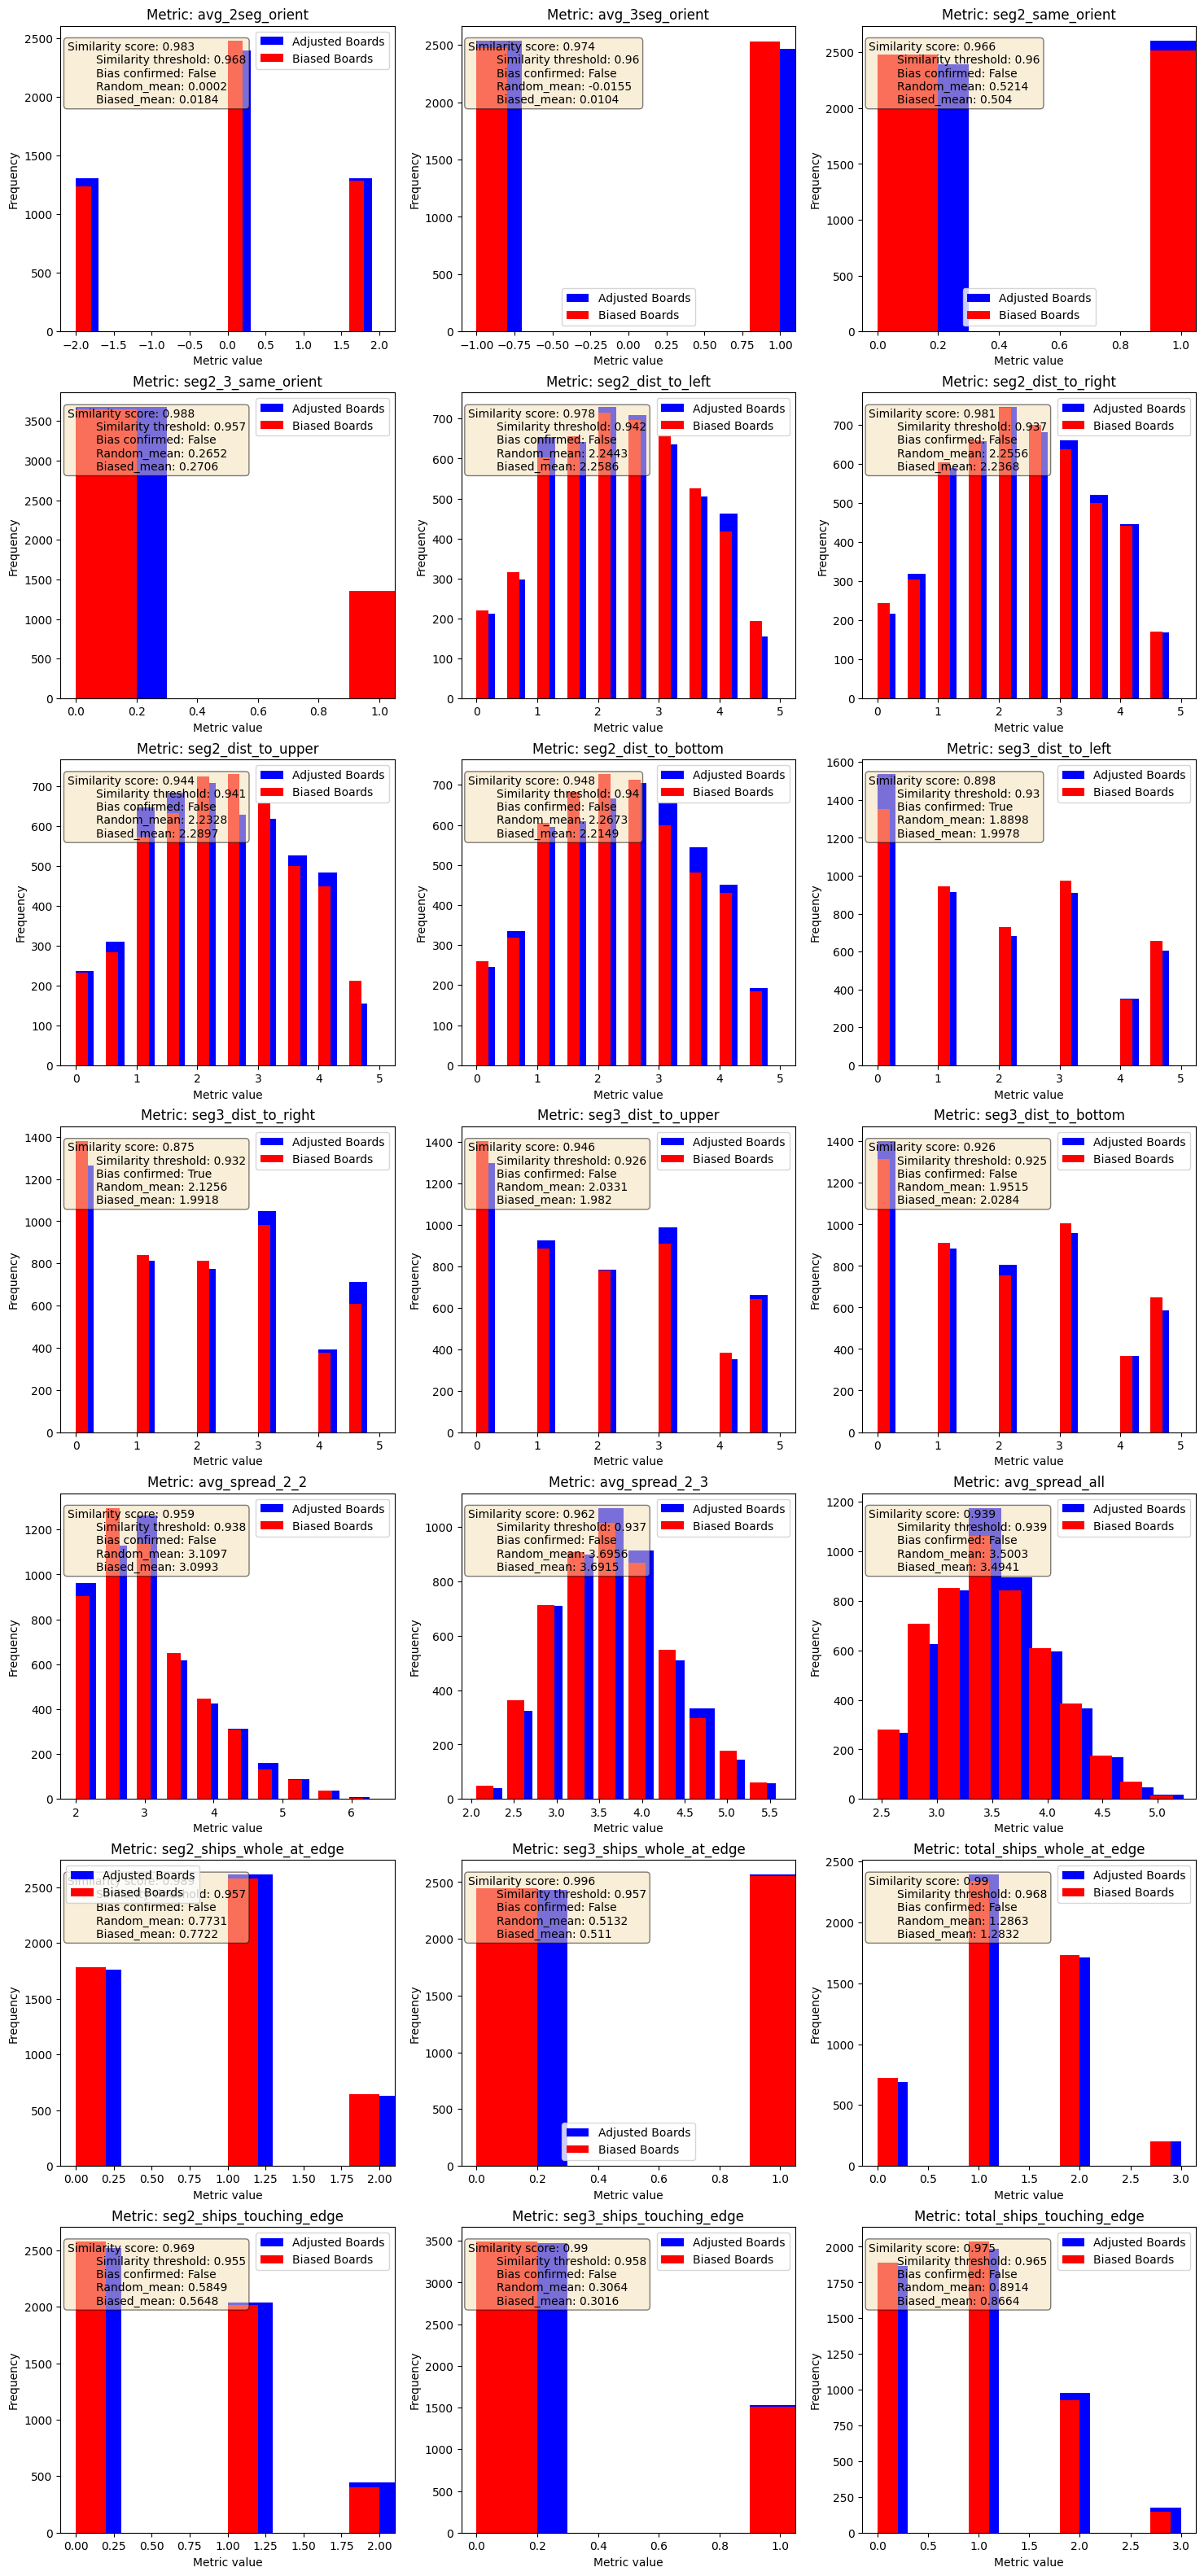

In [11]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(7, 3, figsize=(18, 40))

def draw_histograms (biased_boards_test, adjusted_boards, metrics_list, metrics_per_board_new, metrics_per_board_biased, metrics_sim):

    factor = len(biased_boards_test) /len(adjusted_boards) # factor to scale histogram data

    for id, metric in enumerate(metrics_list):

        if metric == "seg2_3_same_orient" or metric == "seg2_same_orient": # histogram won't accept boolean values
            random_data_for_histogram = [float(metrics_per_board_new[board][metric]) for board in  adjusted_boards]
            biased_data_for_histogram = [float(metrics_per_board_biased[board][metric]) for board in  biased_boards_test]
        else:
            random_data_for_histogram = [metrics_per_board_new[board][metric] for board in  adjusted_boards]
            biased_data_for_histogram = [metrics_per_board_biased[board][metric] for board in  biased_boards_test]
        
        axes = axs.flatten()
        ax = axes[id]

        ax.hist(random_data_for_histogram, bins=10, alpha=1.0, label='Adjusted Boards', color='blue', width=0.3, weights=factor*np.ones_like(random_data_for_histogram))
        ax.hist(biased_data_for_histogram, bins=10, alpha=1.0, label='Biased Boards', color='red', width=0.2)
        ax.text(0.02, 0.95,\
        f'Similarity score: {metrics_sim.loc[metric, "distribution similarity"]}\n\
        Similarity threshold: {metrics_sim.loc[metric, "threshold"]}\n\
        Bias confirmed: {metrics_sim.loc[metric, "bias confirmed"]}\n\
        Random_mean: {metrics_sim.loc[metric, "avg_random"]}\n\
        Biased_mean: {metrics_sim.loc[metric, "avg_biased"]}',\
        transform=ax.transAxes, verticalalignment='top', ha="left", bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
        ax.legend()
        
        ax.set_xlabel('Metric value')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Metric: {metric}')

draw_histograms (biased_boards_test, adjusted_boards, metrics_list, metrics_per_board_new, metrics_per_board_biased, metrics_sim)

Since the outcome is not perfect, I'd like to play around with model parameters, number of training samples and shuffling of train/test data.

To do it efficiently, below I implemented a full pipeline with cross-validation of train-test data split aswell as bootstrap sampling of random boards with adjusted weights.


compare_metrics_nboots - This compares metric distributions between biased and adjusted boards for multiple boots (n_boots)

adapt_to_bias_nboots - Trains the model and uses it to calculate weights for sampled boards, creating adjusted boards lists

cross_val_adapt - Cross validates for different train-test data splits

In [12]:
import copy
from sklearn.model_selection import train_test_split

def compare_metrics_nboots (biased_boards_test, adjusted_boards_nboots, metrics_percentiles_per_n_boards, sample_size, n_boots = 10):
    # Read database containing pre-calculated metrics info per board code
    metrics_per_board_df = pd.read_csv("bias_checks\\all_boards_with_metrics_no_label_updated.csv")
    
    # Summary df for all boots
    metrics_sim_total = pd.DataFrame()

    # For each boot we have a different adjusted boards list
    for id, adjusted_boards in enumerate(adjusted_boards_nboots):      
        # Check if any board code from adjusted_boards or biased_boards_test lists are missing in metrics database.
        # If they are missing, calculate their metrics and update the database
        available_boards = set(metrics_per_board_df["board"])
        missing_A = [x for x in adjusted_boards if x not in available_boards]
        missing_B = [x for x in biased_boards_test if x not in available_boards]
        missing = missing_A + missing_B
        if missing:
            print("Found boards without pre-calculated metrics. Adding them.")
            metrics_per_board_new = get_metrics (missing)
            metrics_per_board_new_df = pd.DataFrame.from_dict(metrics_per_board_new, orient='index').reset_index().rename(columns={"index": "board"})
            metrics_per_board_df = pd.concat([metrics_per_board_df, metrics_per_board_new_df], ignore_index = True).drop_duplicates(subset=['board'])
            metrics_per_board_df.to_csv("bias_checks\\all_boards_with_metrics_no_label_updated.csv", index=False)

        # Create adjusted & biased dataframes with multiple occurances of each board
        adjusted_boards_df = pd.DataFrame({"board": adjusted_boards})
        adjusted_boards_metrics_df = adjusted_boards_df.merge(metrics_per_board_df, on="board", how="left")
        biased_boards_test_df = pd.DataFrame({"board": biased_boards_test})
        biased_boards_test_metrics_df = biased_boards_test_df.merge(metrics_per_board_df, on="board", how="left")

        # Calculate similarity scores
        metric_similarities = {}
        metric_averages_A = {}
        metric_averages_B = {}
        for metric in metrics_list:
            metric_values_A = adjusted_boards_metrics_df[metric].tolist()
            metric_values_B = biased_boards_test_metrics_df[metric].tolist()

            sim = wasserstein_similarity(metric_values_A, metric_values_B)
            metric_similarities[metric] = round(sim, 3)

            metric_averages_A[metric] = np.round(np.mean(metric_values_A), 4)
            metric_averages_B[metric] = np.round(np.mean(metric_values_B), 4)

        # Create summary df for current boot
        metrics_sim = pd.DataFrame.from_dict(metric_similarities, orient='index', columns=['distribution similarity'])
        metrics_sim ['threshold'] = metrics_percentiles_per_n_boards[f'n{sample_size}']

        # Create or update summary df for all boots
        if not metrics_sim_total.empty:
            metrics_sim_total['distribution similarity'] += metrics_sim['distribution similarity']
        else:
            metrics_sim_total = copy.deepcopy(metrics_sim)
        
        # # Print progress
        # print(f'Finished metrics comparison {id+1} out of {n_boots}')

    # Add helper columns in summary df for all boots
    metrics_sim_total['distribution similarity'] /= n_boots
    metrics_sim_total ['bias confirmed'] = metrics_sim_total['distribution similarity'] < metrics_sim_total['threshold']
    metrics_sim_total ['avg_random'] = pd.Series(metric_averages_A)
    metrics_sim_total ['avg_biased'] = pd.Series(metric_averages_B)

    # print("\nMetrics similarities between adjusted boards and biased relational boards:")
    # print(metrics_sim_total)

    return metrics_sim_total


def adapt_to_bias_nboots(random_boards, biased_boards, random_boards_df, biased_boards_train_df, biased_boards_test_df, scaler, clf, sample_size, n_boots):

    red_boards_df = pd.concat([random_boards_df, biased_boards_train_df])

    # Class weights for Likelyhood Ratio weighting
    class_weights = get_class_weights(red_boards_df)

    # Scale based on passed scaler (precalculated on random boards only) and extract scaler params
    X = red_boards_df.drop(columns=['label'])
    Xs = scaler.transform(X)
    scaler_params=(scaler.center_, scaler.scale_, X.columns.tolist())

    # Fit classifier model
    clf.fit(Xs, red_boards_df['label'])

    # Sample boards from random boards set, predict their LR and apply weights
    adjusted_boards_nboots = []
    for _ in range(n_boots):
        adjusted_boards = sample_adjusted_boards(random_boards, clf, scaler_params, class_weights, size = sample_size)
        adjusted_boards_nboots.append(adjusted_boards)

    # Get list of biased board codes
    biased_boards_test = biased_boards_test_df.index.values.tolist()

    print(f'Finished predictions and weights')

    # Compare metrics of adjusted vs biased boards
    metrics_sim_total = compare_metrics_nboots (biased_boards_test, adjusted_boards_nboots, metrics_percentiles_per_n_boards, sample_size, n_boots = n_boots)

    return metrics_sim_total


def cross_val_adapt(random_boards, biased_boards, all_boards_df, scaler, clf, n_boots, sample_size, n_CV_shuffles):
    # Slice dataframe to random and biased parts
    test_size = (10_000-sample_size) / 10_000
    random_boards_df = all_boards_df[0:10_000]
    biased_boards_df = all_boards_df[10_000:]

    # Summary df for all CV shuffles
    metrics_sim_total_CV = pd.DataFrame()

    for n in range(n_CV_shuffles):
        # Train-test split. We do not need y_train and y_test here, it will be prepared manually later.
        biased_boards_train_df, biased_boards_test_df, y_train, y_test = train_test_split(biased_boards_df, biased_boards_df['label'], test_size=test_size)
        metrics_sim_total = adapt_to_bias_nboots(random_boards, biased_boards, random_boards_df, biased_boards_train_df, biased_boards_test_df, scaler, clf, sample_size, n_boots)

        # Create or update summary df for all boots
        if not metrics_sim_total_CV.empty:
            metrics_sim_total_CV['distribution similarity'] += metrics_sim_total['distribution similarity']
        else:
            metrics_sim_total_CV = copy.deepcopy(metrics_sim_total)
        
        # Print progress
        print(f'Finished CV shuffles {n+1} out of {n_CV_shuffles}')

    # Add helper columns in summary df for all boots
    metrics_sim_total_CV['distribution similarity'] /= n_CV_shuffles
    metrics_sim_total_CV ['bias confirmed'] = metrics_sim_total_CV['distribution similarity'] < metrics_sim_total_CV['threshold']

    # print(f"\nMetrics similarities between adjusted boards and biased relational boards with {n_CV_shuffles} CrossValidation shuffles:")
    # print(metrics_sim_total_CV)

    return metrics_sim_total_CV

Let's assume 10 cross validation shuffles, 100 boots per shuffle and a sample size of 4096 (to match what we have available in percentiles per board database).

First try will be done with default LogisticRegression() setup 

In [13]:
path = "bias_checks\\LogisticRegression_results\\metrics_adjusted_results_v01.csv"
n_CV_shuffles = 10
if False:
    clf = LogisticRegression()
    np.random.seed(None)
    metrics_sim_total_CV = cross_val_adapt(random_boards, biased_boards, all_boards_df, scaler, clf, n_boots=10, sample_size=4096, n_CV_shuffles=n_CV_shuffles)
    metrics_sim_total_CV.to_csv(path)

metrics_sim_total_CV = pd.read_csv(path)
print(f"\nMetrics similarities between adjusted boards and biased relational boards with {n_CV_shuffles} CrossValidation shuffles and sample size = 4096:")
print(metrics_sim_total_CV)


Metrics similarities between adjusted boards and biased relational boards with 10 CrossValidation shuffles and sample size = 4096:
                   Unnamed: 0  distribution similarity  threshold  bias confirmed  avg_random  avg_biased
0             avg_2seg_orient                  0.97778      0.968           False      0.0584     -0.0142
1             avg_3seg_orient                  0.98094      0.960           False     -0.0258      0.0064
2            seg2_same_orient                  0.97840      0.960           False      0.5160      0.5078
3          seg2_3_same_orient                  0.97818      0.957           False      0.2586      0.2629
4           seg2_dist_to_left                  0.95973      0.942           False      2.2509      2.2697
5          seg2_dist_to_right                  0.96455      0.937           False      2.2345      2.2338
6          seg2_dist_to_upper                  0.95998      0.941           False      2.2531      2.2571
7         seg2_dist_

Not bad, just tiny mismatch still present in avg_spread_all. Looks like the cross-validation helped to blur the imperfections of the results that we saw earlier, at first attempt.

Now let's apply some regularization.

In [14]:
path = "bias_checks\\LogisticRegression_results\\metrics_adjusted_results_v02.csv"
n_CV_shuffles = 10
if False:
    clf = LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=500
    )
    np.random.seed(None)
    metrics_sim_total_CV = cross_val_adapt(random_boards, biased_boards, all_boards_df, scaler, clf, n_boots=10, sample_size=4096, n_CV_shuffles=n_CV_shuffles)
    metrics_sim_total_CV.to_csv(path)

metrics_sim_total_CV = pd.read_csv(path)
print(f"\nMetrics similarities between adjusted boards and biased relational boards with {n_CV_shuffles} CrossValidation shuffles and sample size = 4096:")
print(metrics_sim_total_CV)


Metrics similarities between adjusted boards and biased relational boards with 10 CrossValidation shuffles and sample size = 4096:
                   Unnamed: 0  distribution similarity  threshold  bias confirmed  avg_random  avg_biased
0             avg_2seg_orient                  0.97752      0.968           False      0.0133      0.0091
1             avg_3seg_orient                  0.97733      0.960           False      0.0607     -0.0274
2            seg2_same_orient                  0.97786      0.960           False      0.5085      0.5039
3          seg2_3_same_orient                  0.98220      0.957           False      0.2699      0.2607
4           seg2_dist_to_left                  0.96330      0.942           False      2.2718      2.2599
5          seg2_dist_to_right                  0.96655      0.937           False      2.2249      2.2378
6          seg2_dist_to_upper                  0.95668      0.941           False      2.2548      2.2529
7         seg2_dist_

Better, but not by a great margin. How about switching the solver and regularization type?

In [15]:
path = "bias_checks\\LogisticRegression_results\\metrics_adjusted_results_v03.csv"
n_CV_shuffles = 10
if False:
    clf = LogisticRegression(
        penalty="l1",
        solver="liblinear",
        max_iter=500
    )
    np.random.seed(None)
    metrics_sim_total_CV = cross_val_adapt(random_boards, biased_boards, all_boards_df, scaler, clf, n_boots=10, sample_size=4096, n_CV_shuffles=n_CV_shuffles)
    metrics_sim_total_CV.to_csv(path)

metrics_sim_total_CV = pd.read_csv(path)
print(f"\nMetrics similarities between adjusted boards and biased relational boards with {n_CV_shuffles} CrossValidation shuffles and sample size = 4096:")
print(metrics_sim_total_CV)


Metrics similarities between adjusted boards and biased relational boards with 10 CrossValidation shuffles and sample size = 4096:
                   Unnamed: 0  distribution similarity  threshold  bias confirmed  avg_random  avg_biased
0             avg_2seg_orient                  0.98005      0.968           False      0.0055     -0.0061
1             avg_3seg_orient                  0.97309      0.960           False      0.0032      0.0064
2            seg2_same_orient                  0.97968      0.960           False      0.5023      0.5068
3          seg2_3_same_orient                  0.98133      0.957           False      0.2663      0.2646
4           seg2_dist_to_left                  0.95635      0.942           False      2.3110      2.2366
5          seg2_dist_to_right                  0.95911      0.937           False      2.1877      2.2649
6          seg2_dist_to_upper                  0.96064      0.941           False      2.2696      2.2527
7         seg2_dist_

Not a big deal either.

Performance of the model is very satisfactory regardless of the settings, so I guess I'll have to simply use whichever runs faster.

Another test run with 30 shuffles:

In [16]:
path = "bias_checks\\LogisticRegression_results\\metrics_adjusted_results_v04.csv"
n_CV_shuffles = 30
if False:
    clf = LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=500
    )
    np.random.seed(None)
    metrics_sim_total_CV = cross_val_adapt(random_boards, biased_boards, all_boards_df, scaler, clf, n_boots=10, sample_size=4096, n_CV_shuffles=n_CV_shuffles)
    metrics_sim_total_CV.to_csv(path)

metrics_sim_total_CV = pd.read_csv(path)
print(f"\nMetrics similarities between adjusted boards and biased relational boards with {n_CV_shuffles} CrossValidation shuffles and sample size = 4096:")
print(metrics_sim_total_CV)


Metrics similarities between adjusted boards and biased relational boards with 30 CrossValidation shuffles and sample size = 4096:
                   Unnamed: 0  distribution similarity  threshold  bias confirmed  avg_random  avg_biased
0             avg_2seg_orient                 0.979717      0.968           False      0.0437     -0.0017
1             avg_3seg_orient                 0.980057      0.960           False     -0.0004      0.0268
2            seg2_same_orient                 0.977120      0.960           False      0.5218      0.5019
3          seg2_3_same_orient                 0.979757      0.957           False      0.2760      0.2622
4           seg2_dist_to_left                 0.961497      0.942           False      2.2990      2.2646
5          seg2_dist_to_right                 0.963447      0.937           False      2.1901      2.2359
6          seg2_dist_to_upper                 0.958393      0.941           False      2.2715      2.2525
7         seg2_dist_

Now let's switch to significantly lower number of samples = 1024

In [17]:
path = "bias_checks\\LogisticRegression_results\\metrics_adjusted_results_v05.csv"
n_CV_shuffles = 10
if False:
    clf = LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=500
    )
    np.random.seed(None)
    metrics_sim_total_CV = cross_val_adapt(random_boards, biased_boards, all_boards_df, scaler, clf, n_boots=10, sample_size=1024, n_CV_shuffles=n_CV_shuffles)
    metrics_sim_total_CV.to_csv(path)

metrics_sim_total_CV = pd.read_csv(path)
print(f"\nMetrics similarities between adjusted boards and biased relational boards with {n_CV_shuffles} CrossValidation shuffles and sample size = 1024:")
print(metrics_sim_total_CV)


Metrics similarities between adjusted boards and biased relational boards with 10 CrossValidation shuffles and sample size = 1024:
                   Unnamed: 0  distribution similarity  threshold  bias confirmed  avg_random  avg_biased
0             avg_2seg_orient                  0.96176      0.930           False     -0.0279     -0.0020
1             avg_3seg_orient                  0.95595      0.921           False      0.0980     -0.0031
2            seg2_same_orient                  0.96537      0.919           False      0.5269      0.5026
3          seg2_3_same_orient                  0.96330      0.913           False      0.2923      0.2613
4           seg2_dist_to_left                  0.93959      0.863           False      2.2211      2.2700
5          seg2_dist_to_right                  0.94246      0.855           False      2.2859      2.2305
6          seg2_dist_to_upper                  0.93369      0.874           False      2.3489      2.2513
7         seg2_dist_

Similarity scores go down with lower number of samples, but so do the threshold values.

It made me think that we are more likely to observe variations to biased boards with higher number of samples - let's see how it looks with 8192 samples.

In [18]:
path = "bias_checks\\LogisticRegression_results\\metrics_adjusted_results_v06.csv"
n_CV_shuffles = 10
if False:
    clf = LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=500
    )
    np.random.seed(None)
    metrics_sim_total_CV = cross_val_adapt(random_boards, biased_boards, all_boards_df, scaler, clf, n_boots=10, sample_size=8192, n_CV_shuffles=n_CV_shuffles)
    metrics_sim_total_CV.to_csv(path)

metrics_sim_total_CV = pd.read_csv(path)
print(f"\nMetrics similarities between adjusted boards and biased relational boards with {n_CV_shuffles} CrossValidation shuffles and sample size = 8192:")
print(metrics_sim_total_CV)


Metrics similarities between adjusted boards and biased relational boards with 10 CrossValidation shuffles and sample size = 8192:
                   Unnamed: 0  distribution similarity  threshold  bias confirmed  avg_random  avg_biased
0             avg_2seg_orient                  0.97641      0.978            True      0.0467     -0.0343
1             avg_3seg_orient                  0.98548      0.969           False      0.0271      0.0088
2            seg2_same_orient                  0.97752      0.970           False      0.5090      0.4950
3          seg2_3_same_orient                  0.98120      0.970           False      0.2675      0.2572
4           seg2_dist_to_left                  0.95873      0.965            True      2.2678      2.2564
5          seg2_dist_to_right                  0.95932      0.958           False      2.2205      2.2522
6          seg2_dist_to_upper                  0.95591      0.963            True      2.2728      2.3125
7         seg2_dist_

Threshold values grow and actually outpace the scores which our model is able to achieve. It looks like beyond certain point, its inherent inaccuracies (model itself + weighting with capping scheme) are starting to dominate and give away the fact, that our adjusted boards are not the same as the original biased ones.

Anyway, I think the similarity level that we are able to achieve with that is totally fine for the planned use and there's no need to futher improve it now. Maybe one day I'll revisit this in another study.


Being happy with the outcome, I conclude this part of the study here.
In the next one we'll try to make it an online learning model to be able to apply it in main game script.

